In [78]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
SEED = 42

df_train = pd.read_csv("/kaggle/input/jigsaw-agile-community-rules/train.csv")
df_test = pd.read_csv("/kaggle/input/jigsaw-agile-community-rules/test.csv")
sample_submission = pd.read_csv("/kaggle/input/jigsaw-agile-community-rules/sample_submission.csv")

print("train size: ", df_train.shape)
print("test size: ", df_test.shape)

train size:  (2029, 9)
test size:  (10, 8)


In [79]:
df_train.head(3)

,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2,rule_violation
0,0,Banks don't want you to know this! Click here ...,"No Advertising: Spam, referral links, unsolici...",Futurology,If you could tell your younger self something ...,hunt for lady for jack off in neighbourhood ht...,Watch Golden Globe Awards 2017 Live Online in ...,"DOUBLE CEE x BANDS EPPS - ""BIRDS""\n\nDOWNLOAD/...",0
1,1,SD Stream [ ENG Link 1] (http://www.sportsstre...,"No Advertising: Spam, referral links, unsolici...",soccerstreams,[I wanna kiss you all over! Stunning!](http://...,LOLGA.COM is One of the First Professional Onl...,#Rapper \n🚨Straight Outta Cross Keys SC 🚨YouTu...,[15 Amazing Hidden Features Of Google Search Y...,0
2,2,Lol. Try appealing the ban and say you won't d...,No legal advice: Do not offer or request legal...,pcmasterrace,Don't break up with him or call the cops. If ...,It'll be dismissed: https://en.wikipedia.org/w...,Where is there a site that still works where y...,Because this statement of his is true. It isn'...,1


In [80]:
df_test.head()

,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2
0,2029,NEW RAP GROUP 17. CHECK US OUT https://soundcl...,"No Advertising: Spam, referral links, unsolici...",hiphopheads,"Hey, guys, just wanted to drop in and invite y...",Cum Swallowing Hottie Katrina Kaif Cartoon Xvi...,SD Stream Eng - [Chelsea TV USA](http://soccer...,HD Streams: |[ENG HD Stoke vs Manchester Unite...
1,2030,Make your life comfortable. Get up to 15% Disc...,No legal advice: Do not offer or request legal...,AskReddit,Get a lawyer and get the security camera foota...,That isn't drastic. You tried reaching out to ...,So what are you going to do with the insurance...,It's just for Austria & Germany. If you still ...
2,2031,Kickin' ass and selling underwear!\nJust made ...,"No Advertising: Spam, referral links, unsolici...",gonewild,Good story my friend. Check out my blog at ht...,If you know what exactly you need then you don...,CENTIPEDES\n\nSOME BASED PATRIOTS HAVE CREATED...,[So great! Thanks for sharing.](http://www.che...
3,2032,watch hooters best therein http://clickan...,"No Advertising: Spam, referral links, unsolici...",personalfinance,"Earn 50,000 bonus points with Chase Sapphire P...","Cool, front page! I made this print along with...",[Full HD Movie Online Free](http://www.flickma...,* Karambit Black Pearl\n* 0.02137822 Float (un...
4,2033,bitches for free at this point show all h...,"No Advertising: Spam, referral links, unsolici...",Showerthoughts,code free tyrande --->>> [Imgur](http://i.imgu...,My trade link\nhttps://steamcommunity.com/trad...,**HD** [ mio Stadium 102 HD](http://www.genti....,Infographics is an incredible method for showi...


In [ ]:
df_train.

In [81]:
print('NA in train data:', df_train.isna().values.any())
print('NA in test data:', df_test.isna().values.any())

NA in train data: False
NA in test data: False


In [ ]:
# print('##### body #####')
# print(train_df['body'].iloc[0,])
# print('##### rule #####')
# print(train_df['rule'].iloc[0,])
# print('##### positive_example_1 #####')
# print(train_df['positive_example_1'].iloc[0,])
# print('#####  positive_example_2 #####')
# print(train_df['positive_example_2'].iloc[0,])
# print('##### negative_example_1 #####')
# print(train_df['negative_example_1'].iloc[0,])
# print('##### negative_example_2 #####')
# print(train_df['negative_example_2'].iloc[0,])

# Preparation

In [82]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [108]:
"""
(Gray Rules): Adding Test data
"""
df_sample = df_test.sample(frac=0.20, random_state=SEED).reset_index(drop=True)

In [84]:
# positives
pos = df_sample[["positive_example_1", "rule", "subreddit"]].rename(
    columns={"positive_example_1": "body"}
)
pos["rule_violation"] = 1

pos_2 = df_sample[["positive_example_2", "rule", "subreddit"]].rename(
    columns={"positive_example_2": "body"}
)
pos_2["rule_violation"] = 1

# negatives
neg = df_sample[["negative_example_1", "rule", "subreddit"]].rename(
    columns={"negative_example_1": "body"}
)
neg["rule_violation"] = 0

neg_2 = df_sample[["negative_example_2", "rule", "subreddit"]].rename(
    columns={"negative_example_2": "body"}
)
neg_2["rule_violation"] = 0

# combine
df_add = pd.concat([pos, pos_2, neg, neg_2], ignore_index=True)

# optional: drop missing texts, ensure int dtype
df_add = df_add.dropna(subset=["body"]).reset_index(drop=True)
df_add["rule_violation"] = df_add["rule_violation"].astype(int)

In [86]:
df_train_aug = pd.concat([df_train, df_add], ignore_index=True)

In [87]:
df_train_aug

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2,rule_violation
0,0.0,Banks don't want you to know this! Click here ...,"No Advertising: Spam, referral links, unsolici...",Futurology,If you could tell your younger self something ...,hunt for lady for jack off in neighbourhood ht...,Watch Golden Globe Awards 2017 Live Online in ...,"DOUBLE CEE x BANDS EPPS - ""BIRDS""\n\nDOWNLOAD/...",0
1,1.0,SD Stream [ ENG Link 1] (http://www.sportsstre...,"No Advertising: Spam, referral links, unsolici...",soccerstreams,[I wanna kiss you all over! Stunning!](http://...,LOLGA.COM is One of the First Professional Onl...,#Rapper \n🚨Straight Outta Cross Keys SC 🚨YouTu...,[15 Amazing Hidden Features Of Google Search Y...,0
2,2.0,Lol. Try appealing the ban and say you won't d...,No legal advice: Do not offer or request legal...,pcmasterrace,Don't break up with him or call the cops. If ...,It'll be dismissed: https://en.wikipedia.org/w...,Where is there a site that still works where y...,Because this statement of his is true. It isn'...,1
3,3.0,she will come your home open her legs with an...,"No Advertising: Spam, referral links, unsolici...",sex,Selling Tyrande codes for 3€ to paypal. PM. \n...,tight pussy watch for your cock get her at thi...,NSFW(obviously) http://spankbang.com/iy3u/vide...,Good News ::Download WhatsApp 2.16.230 APK for...,1
4,4.0,code free tyrande --->>> [Imgur](http://i.imgu...,"No Advertising: Spam, referral links, unsolici...",hearthstone,wow!! amazing reminds me of the old days.Well...,seek for lady for sex in around http://p77.pl/...,must be watch movie https://sites.google.com/s...,We're streaming Pokemon Veitnamese Crystal RIG...,1
...,...,...,...,...,...,...,...,...,...
2032,NaN,That isn't drastic. You tried reaching out to ...,No legal advice: Do not offer or request legal...,AskReddit,NaN,NaN,NaN,NaN,0
2033,NaN,The fact that there are pro and cons to everyt...,"No Advertising: Spam, referral links, unsolici...",movies,NaN,NaN,NaN,NaN,1
2034,NaN,So what are you going to do with the insurance...,No legal advice: Do not offer or request legal...,AskReddit,NaN,NaN,NaN,NaN,1
2035,NaN,Oh that's interesting. You should check out my...,"No Advertising: Spam, referral links, unsolici...",movies,NaN,NaN,NaN,NaN,1


In [88]:
y = df_train_aug["rule_violation"]

# Public Score: 0.584
X = df_train_aug["body"]

In [89]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=SEED)

# Bert Model

In [90]:
# Token and Encode Function
def tokenize_and_encode(tokenizer, comments, labels, max_length=128):
    # Initialize empty lists to store tokenized inputs and attention masks
    input_ids = []
    attention_masks = []

    # Iterate through each comment in the 'comments' list
    for comment in comments:

        # Tokenize and encode the comment using the BERT tokenizer
        encoded_dict = tokenizer.encode_plus(
            comment,

            # Add special tokens like [CLS] and [SEP]
            add_special_tokens=True,

            truncation=True,
            
            # Truncate or pad the comment to 'max_length'
            max_length=max_length,

            # Pad the comment to 'max_length' with zeros if needed
            padding='max_length',

            # Return attention mask to mask padded tokens
            return_attention_mask=True,

            # Return PyTorch tensors
            return_tensors='pt'
        )

        # Append the tokenized input and attention mask to their respective lists
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Concatenate the tokenized inputs and attention masks into tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    # Convert the labels to a PyTorch tensor with the data type float32
    labels = torch.tensor(labels, dtype=torch.float32)

    # Return the tokenized inputs, attention masks, and labels as PyTorch tensors
    return input_ids, attention_masks, labels

In [ ]:
from transformers import AutoTokenizer, RobertaForSequenceClassification

# tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
# model = RobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-base", num_labels=1)

In [ ]:
# model.save_pretrained("my-roberta-base-cls")
# tokenizer.save_pretrained("my-roberta-base-cls")

In [91]:
MODEL_DIR = "/kaggle/input/my-base-bert/my-bert-cls"

tokenizer = BertTokenizer.from_pretrained(
    MODEL_DIR,
    do_lower_case=True,
    local_files_only=True
)

config = BertConfig.from_pretrained(
    MODEL_DIR,
    local_files_only=True
)

model = BertForSequenceClassification.from_pretrained(
    MODEL_DIR,
    config=config,
    local_files_only=True
)

# Train

In [92]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

In [94]:
# Tokenize and Encode the comments and labels for the training set
input_ids, attention_masks, labels = tokenize_and_encode(
    tokenizer,
    X_train,
    y_train.values
)

# Tokenize and Encode the comments and labels for the validation set
val_input_ids, val_attention_masks, val_labels = tokenize_and_encode(
    tokenizer,
    X_val,
    y_val.values
)

print('Training Comments :',X_train.shape)
print('Input Ids         :',input_ids.shape)
print('Attention Mask    :',attention_masks.shape)
print('Labels            :',labels.shape)

Training Comments : (1425,)
Input Ids         : torch.Size([1425, 128])
Attention Mask    : torch.Size([1425, 128])
Labels            : torch.Size([1425])


In [95]:
# Creating DataLoader for the balanced dataset
batch_size = 32
train_dataset = TensorDataset(input_ids, attention_masks, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# validation set 
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Optimizer
# from torch.optim
# optimizer = AdamW(model.parameters(), lr=0.0001)

In [97]:
def plot_traing(train_losses, val_losses, train_f1s, val_f1s):

    plt.figure(figsize=(12, 5))

    # Training Loss & Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Training Accuracy & Validation F1 Score
    plt.subplot(1, 2, 2)
    plt.plot(train_f1s, label='Train Accuracy')
    plt.plot(val_f1s, label='Val F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Accuracy & F1 Score over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [98]:
import copy
from sklearn.metrics import accuracy_score, f1_score

def train_model(model, train_loader, val_loader, device, num_epochs, patience=5):
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    best_f1 = -1.0
    epochs_no_improve = 0
    best_state = None

    train_losses = []
    train_f1s = []
    val_losses = []
    val_f1s = []
    
    for epoch in range(num_epochs):

        model.train()
        total_loss = 0.0
        all_train_preds, all_train_labels = [], []
        # train
        for batch in train_loader:
            
            input_ids, attention_mask, labels = [t.to(device) for t in batch]
            labels = labels.float()

            # prediction (number of batches)
            output = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = output.logits.squeeze(-1)
            probs = torch.sigmoid(logits)  # convert logits to probabilities first
            # print(logits) # DEBUG
            
            # forward pass
            # loss = loss_fn(logits, labels)
            loss = loss_fn(probs, labels)
            # print(loss) # DEBUG
            
            total_loss += loss.item()

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # update weights
            optimizer.step()

            preds = (probs > 0.5).long()
            all_train_preds.extend(preds.cpu().tolist())
            all_train_labels.extend(labels.cpu().tolist())

            # break # DEBUG
        
        train_loss = total_loss / len(train_loader)
        train_f1 = f1_score(all_train_labels, all_train_preds)

        train_losses.append(train_loss)
        train_f1s.append(train_f1)
        
        # Validate
        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [t.to(device) for t in batch]
                labels = labels.float()
                output = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = output.logits.squeeze(-1)
                probs = torch.sigmoid(logits)
                val_loss += loss_fn(probs, labels.float()).item()
                
                preds = (probs > 0.5).long()
                all_preds.extend(preds.cpu().tolist())
                all_labels.extend(labels.cpu().tolist())
                
        val_loss /= len(val_loader)
        val_f1 = f1_score(all_labels, all_preds)

        val_losses.append(val_loss)
        val_f1s.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_f1:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            epochs_no_improve = 0
            best_state = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping (no val F1 improvement for {patience} epochs). Best Val F1: {best_f1:.4f}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)


    # visualize training
    plot_traing(train_losses, val_losses, train_f1s, val_f1s)


    return model, best_f1

Epoch 1/50 - Train Loss: 0.5873, Train Acc: 0.6831 - Val Loss: 0.4802, Val F1: 0.7640
Epoch 2/50 - Train Loss: 0.4338, Train Acc: 0.8202 - Val Loss: 0.5141, Val F1: 0.7584
Epoch 3/50 - Train Loss: 0.3125, Train Acc: 0.8787 - Val Loss: 0.6035, Val F1: 0.7429
Epoch 4/50 - Train Loss: 0.1946, Train Acc: 0.9307 - Val Loss: 0.7036, Val F1: 0.7923
Epoch 5/50 - Train Loss: 0.1060, Train Acc: 0.9672 - Val Loss: 0.7113, Val F1: 0.7927
Epoch 6/50 - Train Loss: 0.0729, Train Acc: 0.9791 - Val Loss: 0.7707, Val F1: 0.7769
Epoch 7/50 - Train Loss: 0.0777, Train Acc: 0.9742 - Val Loss: 0.9554, Val F1: 0.7812
Epoch 8/50 - Train Loss: 0.0597, Train Acc: 0.9812 - Val Loss: 0.9460, Val F1: 0.7931
Epoch 9/50 - Train Loss: 0.0431, Train Acc: 0.9882 - Val Loss: 1.2919, Val F1: 0.7785
Epoch 10/50 - Train Loss: 0.1027, Train Acc: 0.9688 - Val Loss: 1.0219, Val F1: 0.7803
Epoch 11/50 - Train Loss: 0.0595, Train Acc: 0.9826 - Val Loss: 1.0633, Val F1: 0.7847
Epoch 12/50 - Train Loss: 0.0320, Train Acc: 0.9888 

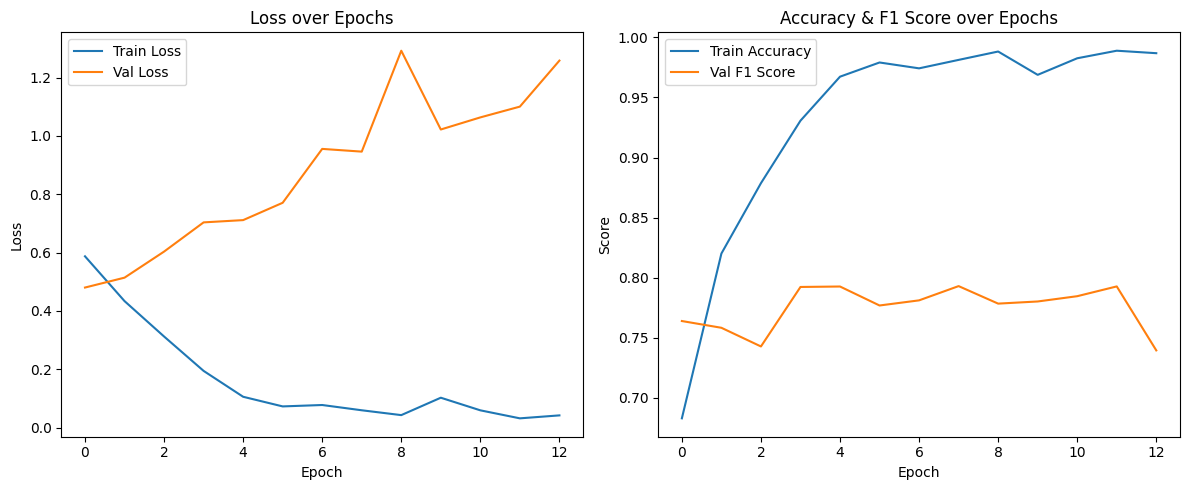

In [99]:
# Call the function to train the model
model, best_f1 = train_model(model, train_loader, val_loader, device, num_epochs=50, patience=5)


# Inference

In [111]:
def tokenize_test(tokenizer, comments, max_length=128):
    input_ids, attention_masks = [], []
    for comment in comments:
        enc = tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=max_length,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt",
        )
        input_ids.append(enc["input_ids"])
        attention_masks.append(enc["attention_mask"])
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

test_input_ids, test_attention_masks = tokenize_test(tokenizer, df_test["body"], max_length=128)
test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [101]:
def predict(model, loader, device):
    model.eval()
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for batch in loader:
            input_ids, attention_mask = [t.to(device) for t in batch]
            
            output = model(input_ids=input_ids, attention_mask=attention_mask)

            logits = output.logits.squeeze(-1)
            probs = torch.sigmoid(logits)
            all_probs.extend(probs.cpu().tolist())
            
    return all_probs

res = predict(model, test_loader, device)

In [102]:
res

[0.0009915899718180299,
 0.0016882913187146187,
 0.9866265654563904,
 0.9934501647949219,
 0.9957243204116821,
 0.0009926102356985211,
 0.9800665378570557,
 0.001077479450032115,
 0.0009086434147320688,
 0.9937763214111328]

In [103]:
submission = pd.DataFrame(df_test["row_id"])
submission["rule_violation"] = res

In [106]:
submission

,row_id,rule_violation
0,2029,0.000992
1,2030,0.001688
2,2031,0.986627
3,2032,0.993450
4,2033,0.995724
5,2034,0.000993
6,2035,0.980067
7,2036,0.001077
8,2037,0.000909
9,2038,0.993776


In [107]:
submission.to_csv('submission.csv', index=False)